In [1]:
import matplotlib.pyplot as plt
        
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import ImageNormalize, SqrtStretch

import sunpy.map
from sunpy.coordinates import propagate_with_solar_surface
from sunpy.net import Fido
from sunpy.net import attrs as a

query = Fido.search(a.Time('2018-05-30 02:00:00', '2018-05-30 10:00:00'),
                    a.Instrument.aia,
                    a.Wavelength(171*u.angstrom),
                    a.Sample(1*u.hr))
print(query)
files = Fido.fetch(query)


/home/xoein/anaconda3/envs/sunpy5/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Results from 1 Provider:

8 Results from the VSOClient:
Source: https://sdac.virtualsolar.org/cgi/search
Total estimated size: 542.31 Mbyte

       Start Time               End Time        Source Instrument   Wavelength   Provider  Physobs  Wavetype Extent Width Extent Length Extent Type   Size  
                                                                     Angstrom                                                                        Mibyte 
----------------------- ----------------------- ------ ---------- -------------- -------- --------- -------- ------------ ------------- ----------- --------
2018-05-30 02:00:09.000 2018-05-30 02:00:10.000    SDO        AIA 171.0 .. 171.0     JSOC intensity   NARROW         4096          4096    FULLDISK 64.64844
2018-05-30 03:00:09.000 2018-05-30 03:00:10.000    SDO        AIA 171.0 .. 171.0     JSOC intensity   NARROW         4096          4096    FULLDISK 64.64844
2018-05-30 04:00:09.000 2018-05-30 04:00:10.000    SDO        AIA 171.0 ..

Files Downloaded: 100%|██████████| 8/8 [00:05<00:00,  1.40file/s]


['/home/xoein/sunpy/data/aia.lev1.171A_2018_05_30T02_00_09.35Z.image_lev1.fits', '/home/xoein/sunpy/data/aia.lev1.171A_2018_05_30T03_00_09.35Z.image_lev1.fits', '/home/xoein/sunpy/data/aia.lev1.171A_2018_05_30T04_00_09.35Z.image_lev1.fits', '/home/xoein/sunpy/data/aia.lev1.171A_2018_05_30T05_00_09.35Z.image_lev1.fits', '/home/xoein/sunpy/data/aia.lev1.171A_2018_05_30T06_00_09.35Z.image_lev1.fits', '/home/xoein/sunpy/data/aia.lev1.171A_2018_05_30T07_00_09.35Z.image_lev1.fits', '/home/xoein/sunpy/data/aia.lev1.171A_2018_05_30T08_00_09.35Z.image_lev1.fits', '/home/xoein/sunpy/data/aia.lev1.171A_2018_05_30T09_00_09.35Z.image_lev1.fits']


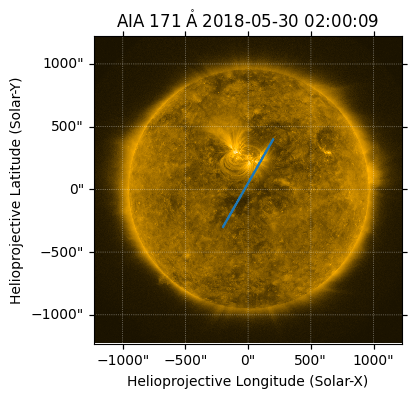

In [2]:
print(files)
aia_sequence = sunpy.map.Map(files, sequence=True)

# fig = plt.figure()
# ax = fig.add_subplot(projection=aia_sequence[0])
norm = norm=ImageNormalize(vmin=0, vmax=3e3, stretch=SqrtStretch())
# ani = aia_sequence.plot(axes=ax, norm=norm)

line_coords = SkyCoord([-200, 200], [-300, 400], unit=(u.arcsec, u.arcsec),
                       frame=aia_sequence[0].coordinate_frame)

intensity_coords = sunpy.map.pixelate_coord_path(aia_sequence[0], line_coords)
intensity = sunpy.map.sample_at_coords(aia_sequence[0], intensity_coords)



fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121, projection=aia_sequence[0])
aia_sequence[0].plot(axes=ax1)
ax1.plot_coord(intensity_coords)

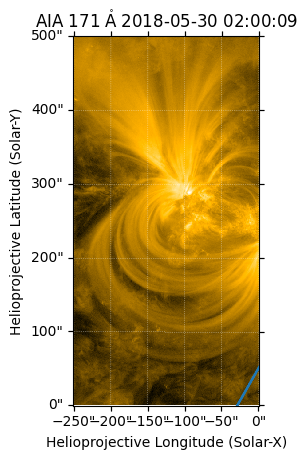

In [3]:
corner = SkyCoord(Tx=-250*u.arcsec, Ty=0*u.arcsec, frame=aia_sequence[0].coordinate_frame)
width = 250*u.arcsec
cutout_map = aia_sequence[0].submap(corner, width=width, height=500*u.arcsec)

fig = plt.figure()
ax = fig.add_subplot(projection=cutout_map)
ax.plot_coord(intensity_coords)
cutout_map.plot(axes=ax)


In [4]:
with propagate_with_solar_surface():
    aia_sequence_aligned = sunpy.map.Map([m.reproject_to(cutout_map.wcs) for m in aia_sequence], sequence=True)


2024-12-22 09:16:27 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2024-12-22 09:16:27 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2024-12-22 09:16:28 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2024-12-22 09:16:28 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2024-12-22 09:16:29 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2024-12-22 09:16:30 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2024-12-22 09:16:31 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2024-12-22 09:16:31 - reproject.common - INFO: Calling _reproject_full in non-dask mode


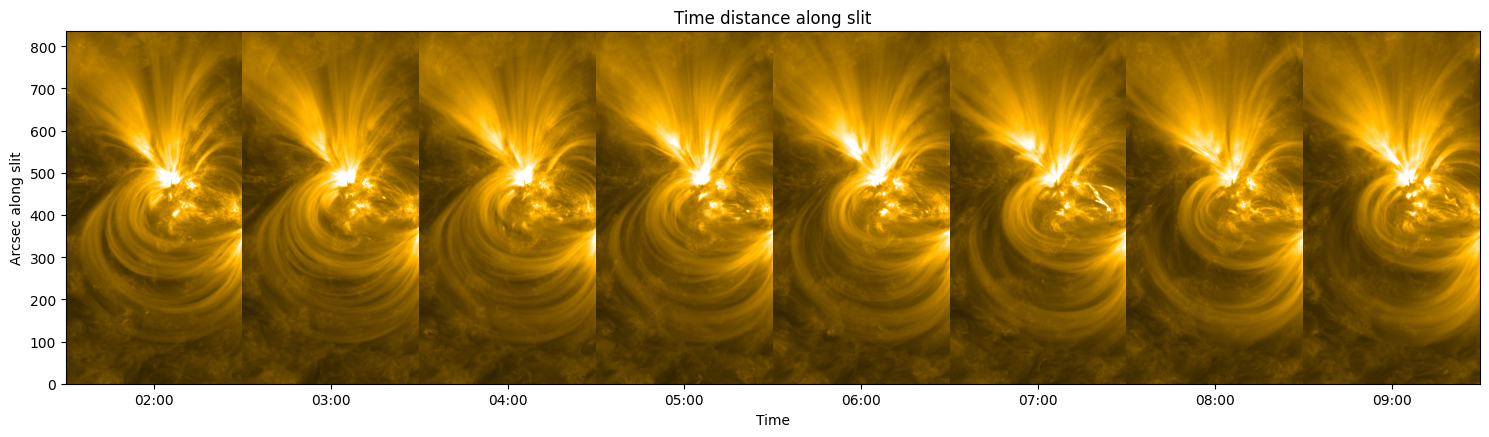

In [5]:
fig, ax = plt.subplots(figsize=(15, 6))  

x_offset = 0
time_ticks = []
time_labels = []

for i, m in enumerate(aia_sequence_aligned):
    extent = [x_offset, x_offset + m.data.shape[1], 0, m.data.shape[0]]
    ax.imshow(m.data, origin='lower', cmap='sdoaia171', extent=extent, norm=norm)
    

    time_ticks.append(x_offset + m.data.shape[1] / 2)  
    time_labels.append(aia_sequence[i].date.strftime('%H:%M'))  

    x_offset += m.data.shape[1]

ax.set_xlim(0, x_offset)
ax.set_ylim(0, m.data.shape[0])  

ax.set_xlabel('Time')
ax.set_ylabel('Arcsec along slit')
ax.set_title('Time distance along slit')

ax.set_xticks(time_ticks)
ax.set_xticklabels(time_labels) 

plt.tight_layout()  
plt.show()
